In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from pandas.core.common import flatten

In [2]:
import torch
import torch.nn 
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import warnings

In [4]:
warnings.filterwarnings("ignore")

## Import and understanding the data


In [8]:
df = pd.read_csv("/kaggle/input/fashion-product-images-small/styles.csv")

ParserError: Error tokenizing data. C error: Expected 10 fields in line 6044, saw 11


In [6]:
# overwrite the error for bad lines
df = pd.read_csv("/kaggle/input/fashion-product-images-small/styles.csv", error_bad_lines = False)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [7]:
df.head(6)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt


In [15]:
df.dtypes

id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
dtype: object

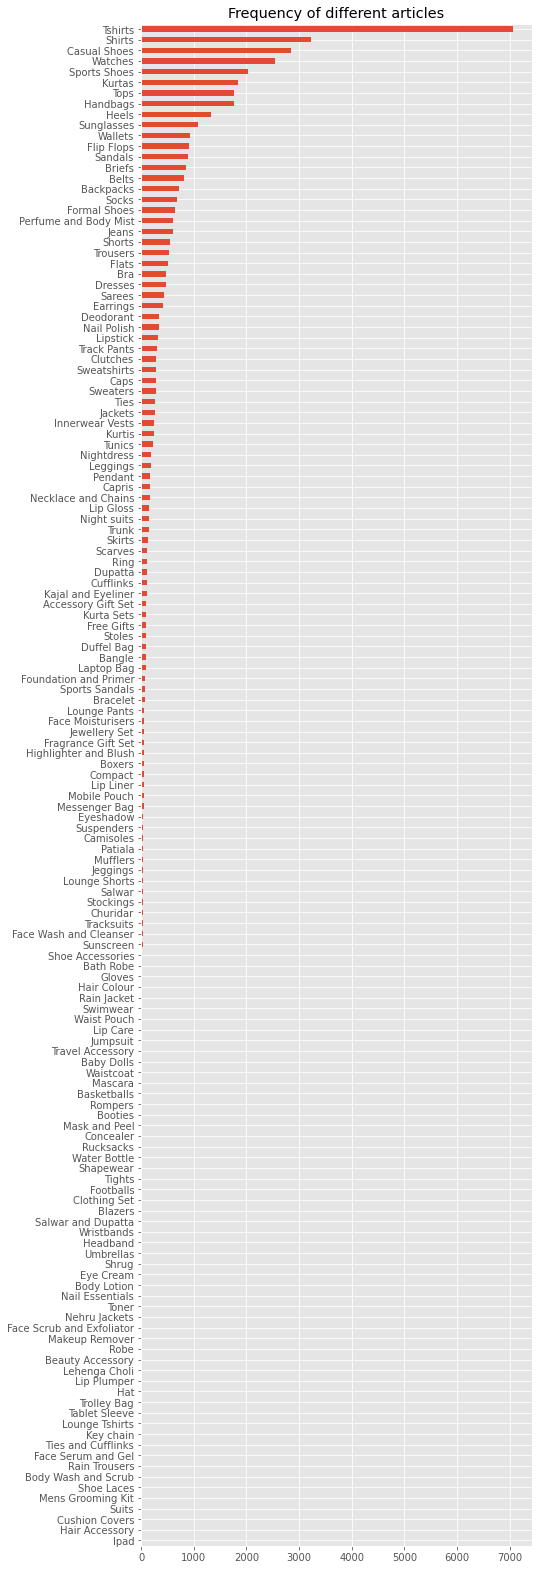

In [17]:
plt.style.use("ggplot")
plt.figure(figsize = (7,28))
df.articleType.value_counts().sort_values().plot(kind = "barh")
plt.title("Frequency of different articles")
plt.show()

In [19]:
df["image"] = df.apply(lambda row : str(row["id"]) + ".jpg" , axis = 1)

In [21]:
df.reset_index(drop = True)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [30]:
df["year"] = df.year.fillna(0.0).apply(lambda x  :  int(x))

- year is float64 => better change to int

In [31]:
df.dtypes

id                     int64
gender                object
masterCategory        object
subCategory           object
articleType           object
baseColour            object
season                object
year                   int64
usage                 object
productDisplayName    object
image                 object
dtype: object

In [34]:
def image_location(img , path):
    return path+ img

In [36]:
def load_img(image,path ):
    """
    expecting path to be "/directory/"
    """
    image_path = path + image
    image = cv2.imread(image_path)
    return image

In [69]:
def show_images(images , rows=1 , cols = 1, figsize=(12,12)):
    fig, axes = plt.subplots(ncols = cols, nrows = rows, figsize = figsize)
    # looping the images 
    for index, name in enumerate(images):
        axes.ravel()[index].imshow( cv2.cvtColor(images[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()
path =  "/kaggle/input/fashion-product-images-small/images/" 
images = {"img_" +str(i) : load_img(row.image , path) for i , row in df.sample(6).iterrows()}



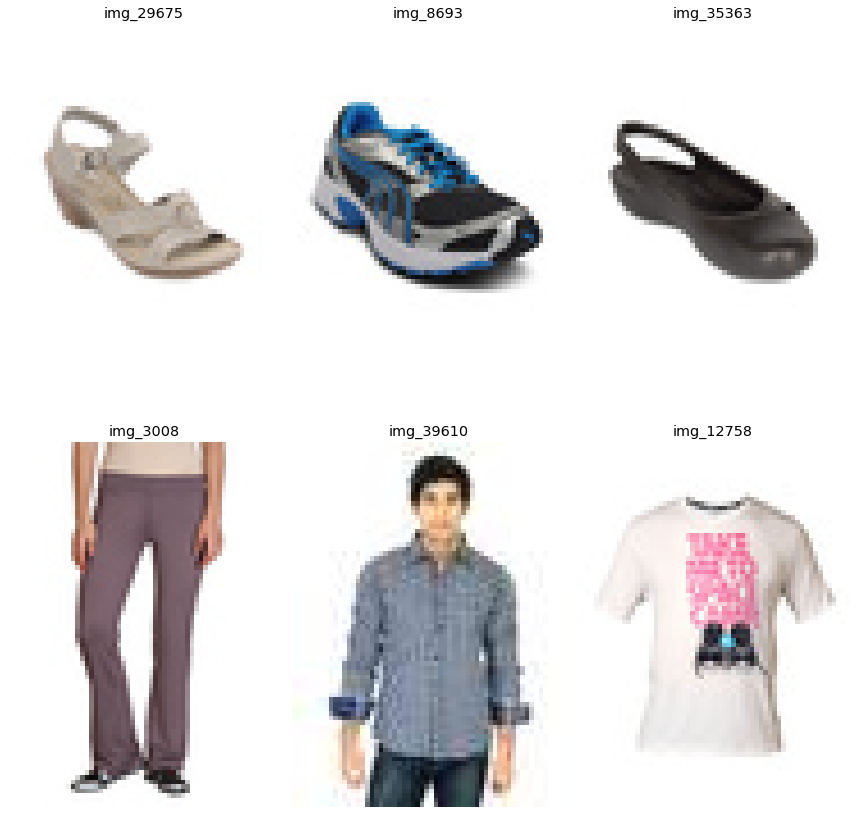

In [70]:
show_images(images, 2,3)

In [94]:
#cv2.imshow("", cv2.cvtColor(cv2.imread('/kaggle/input/fashion-product-images-small/images/15970.jpg') , cv2.COLOR_BGR2RGB) )

In [93]:
path+df.head()["image"][1]

'/kaggle/input/fashion-product-images-small/images/39386.jpg'

In [54]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [64]:
path

'/kaggle/input/fashion-product-images-small/images'

In [65]:
"/kaggle/input/fashion-product-images-small/images/"+df.head()["image"][0]

'/kaggle/input/fashion-product-images-small/images/15970.jpg'

In [96]:
Image.open('/kaggle/input/fashion-product-images-small/images/15970.jpg').size

(60, 80)

In [97]:
width = 224
height = 224
resnetmodel = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [99]:
layer = resnetmodel._modules.get("avgpool")

In [100]:
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Transformations

In [104]:
s_data = transforms.Resize((224, 224))
standardize = transforms.Normalize(mean = [0.7, 0.6 , 0.3] , 
                                  std = [0.2, 0.3, 0.1])
convert_tensor = transforms.ToTensor()

In [113]:
missing_img = []
def vector_extraction(resnetmodel, image_id, path):
    try:
        img = Image.open(image_location(image_id, path)).convert("RGB")
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        embeddings = torch.zeros(512)
        def select_d(m, i , o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
        hlayer = layer.register_forward_hook(select_d)
        resnetmodel(t_img)
        hlayer.remove()
        emb = embeddings 
        return embeddings
    except FileNotFoundError:
        missing_imgs = df[df["image"] == image_id].index
        missing_img.append(missing_imgs)
        print("exception")
        

In [114]:
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image , path)

In [116]:
sample_embedding_1 = vector_extraction(resnetmodel, df.iloc[1000].image , path)

## finding similarity between 2 images

In [117]:
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0), sample_embedding_1.unsqueeze(0))

In [118]:
cos_sim

array([[0.8628776]], dtype=float32)

In [119]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 3.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=cf53793966e3b3f2986a4bfc6b391857934e18fe4424b5f94d6f7ffa27e6b5e5
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter


In [120]:
import swifter

In [121]:
df_embeddings = df[:5000]

In [122]:
map_embeddings = df_embeddings["image"].swifter.apply(lambda img : vector_extraction(resnetmodel, img , path))

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

In [124]:
df_embs = map_embeddings.apply(pd.Series)
df_embs.shape


(5000, 512)

In [125]:
cosine_sim = cosine_similarity(df_embs)
index_vales = pd.Series(range(len(df)), index = df.index)
index_vales

0            0
1            1
2            2
3            3
4            4
         ...  
44419    44419
44420    44420
44421    44421
44422    44422
44423    44423
Length: 44424, dtype: int64

In [128]:
def recommend_images(ImgId, df, top_n = 6):
    sim_ImId = index_vales[ImgId]
    sml_score = list(enumerate(cosine_sim[sim_ImId]))
    sml_score = sorted(sml_score, key = lambda x: x[1], reverse = True)
    sml_score = sml_score[1:top_n+1]
    ImgId_rec = [i[0] for i in sml_score]
    ImgId_sim = [i[1] for i in sml_score]
    
    return index_vales.iloc[ImgId_rec].index , ImgId_sim

In [129]:
recommend_images(3810, df, 5)

(Int64Index([0, 3899, 3678, 634, 4746], dtype='int64'),
 [0.96716744, 0.96288836, 0.9562329, 0.95565605, 0.9534769])

In [132]:
def Rec_viz_image(input_imageid):
    idx_rec , idx_sim = recommend_images(input_imageid, df, top_n = 6)
    print(idx_sim)
    plt.imshow(cv2.cvtColor(load_img(df.iloc[input_imageid].image, path), cv2.COLOR_BGR2RGB))
    figures = {"im"+ str(i): load_img(row.image, path) for i, row in df.loc[idx_rec].iterrows()}
    
    show_images(figures, 2, 3)

[0.96716744, 0.96288836, 0.9562329, 0.95565605, 0.9534769, 0.9519081]


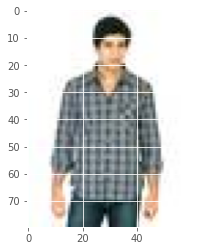

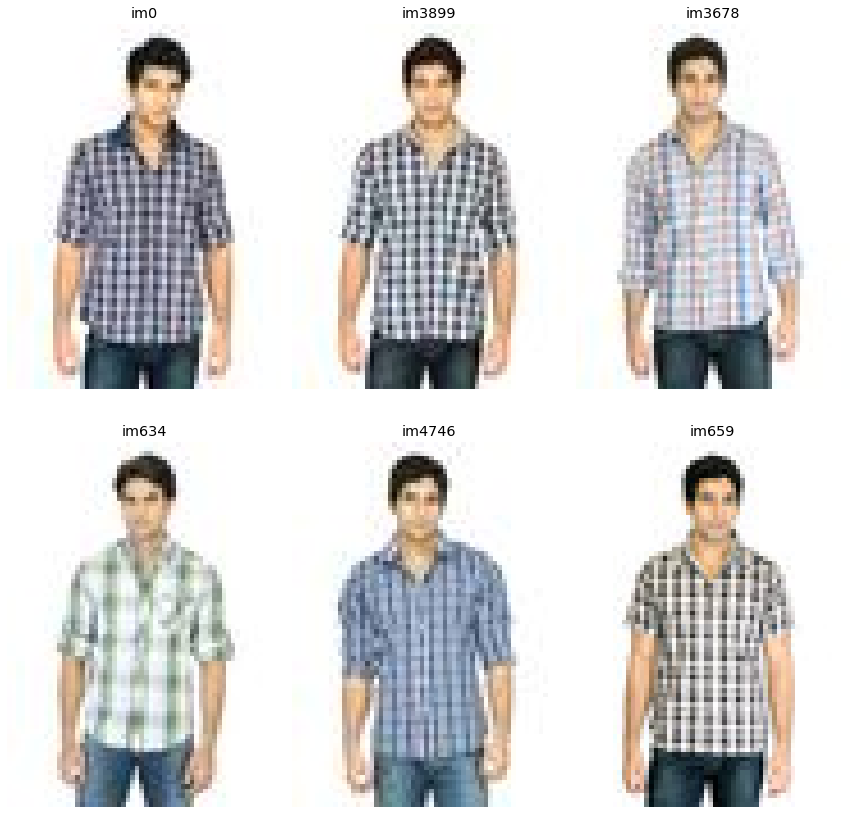

In [133]:
Rec_viz_image(3810)

[0.9799334, 0.9652796, 0.9571782, 0.95654637, 0.9524461, 0.9493822]


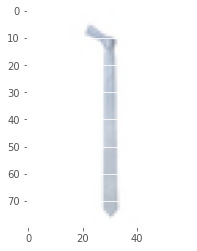

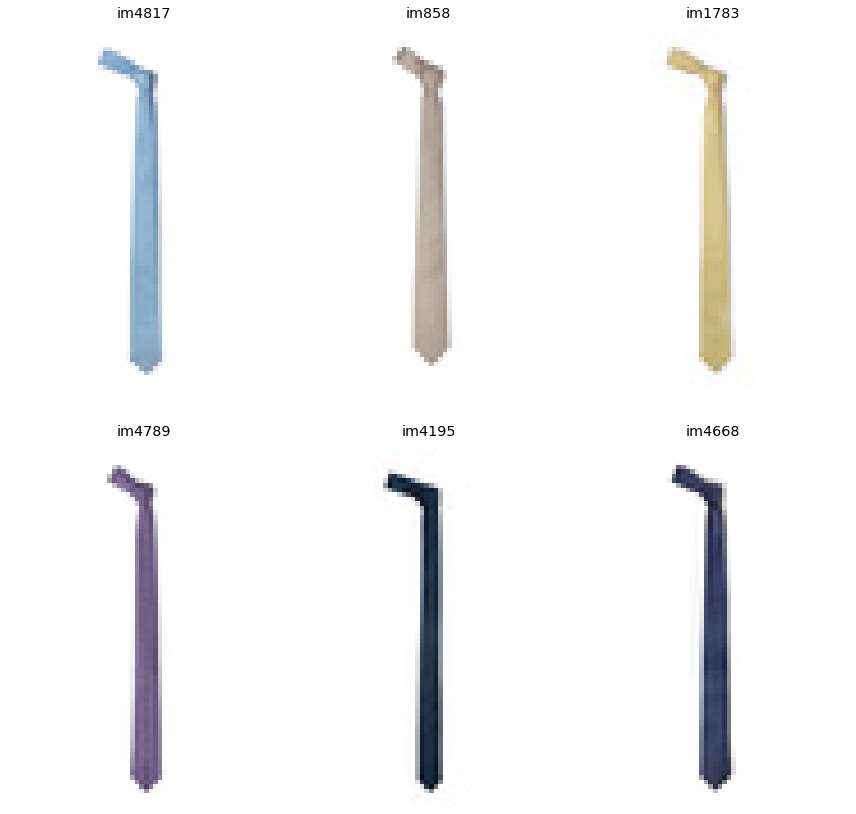

In [134]:
Rec_viz_image(2518)